In [127]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.core.config_loader import ConfigLoader
from src.core.clients.bigquery import BigQueryClient
%matplotlib inline

bq_client = BigQueryClient()
config_loader = ConfigLoader()

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


In [ ]:
from src.core.models.xgboost import XgboostModel

model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260129_170954_3mstklong/model_0.pickle'
)
type(model)

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260129_170954_3mstklong/model_0.pickle


src.core.models.xgboost.XgboostModel

# Predict for the error using a tree regressor
The objective of this exercize is to extract insights of what may be causig the error. 

In [157]:
import numpy as np
df = model.training_df.copy()
df = df[df["ctx_cat_id"]=="FOODS"]
# df["actuals"] = np.expm1(df[config_loader.target_col])
# df['predictions'] = model.predict(df[model.features], True)
# df['error'] = abs(df['predictions'] - df["actuals"])/df["actuals"]

df["actuals"] = df[config_loader.target_col]
df['predictions'] = model.predict(df[model.features], False)
df['error'] = abs(df['predictions'] - df["actuals"])/df["actuals"]
df['bench_error'] = abs(df[config_loader.benchmark_col] - df["actuals"])/df["actuals"]
df['beat_benchmark'] = df['error'] - df['bench_error']


In [158]:
df['error'].mean()

np.float64(0.04920234148019705)

In [161]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=3)
regressor.fit(df[model.features], df['beat_benchmark'])

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [162]:
from sklearn.tree import export_text

tree_rules = export_text(regressor, feature_names=list(model.features), show_weights=True )

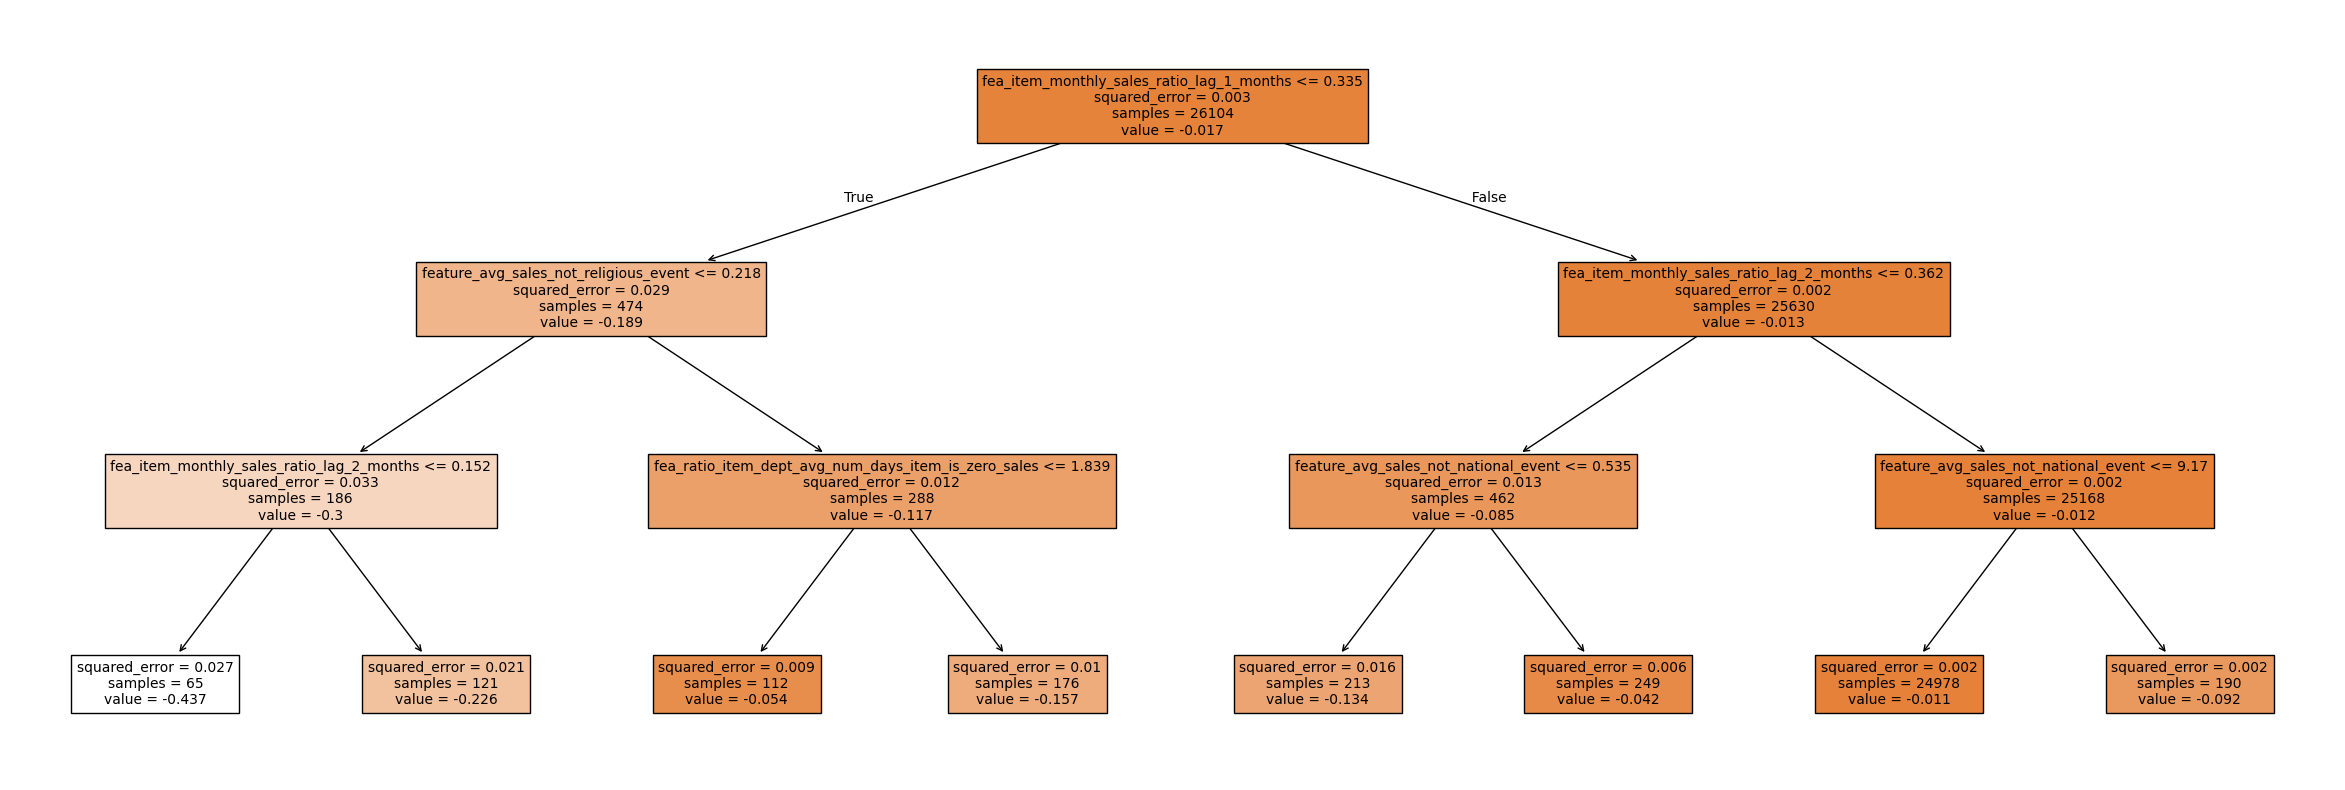

In [163]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 10))
plot_tree(regressor, feature_names=model.features, filled=True, fontsize=10)
plt.show()

In [164]:
import pandas as pd

tree = regressor.tree_
tree_df = pd.DataFrame({
    "feature": [model.features[i] if i != -2 else "leaf" for i in tree.feature],
    "threshold": tree.threshold,
    "value": tree.value.flatten(),
    "n_node_samples": tree.n_node_samples,
    "impurity": tree.impurity,
    "left_child": tree.children_left,
    "right_child": tree.children_right
})
tree_df.to_csv("tree_structure.csv", index=False)

In [165]:
tree_df

,feature,threshold,value,n_node_samples,impurity,left_child,right_child
0,fea_item_monthly_sales_ratio_lag_1_months,0.334983,-0.016502,26104,0.003053,1,8
1,feature_avg_sales_not_religious_event,0.218254,-0.188782,474,0.028550,2,5
2,fea_item_monthly_sales_ratio_lag_2_months,0.151923,-0.299948,186,0.033136,3,4
3,leaf,-2.000000,-0.437345,65,0.027457,-1,-1
4,leaf,-2.000000,-0.226140,121,0.020599,-1,-1
5,fea_ratio_item_dept_avg_num_days_item_is_zero_...,1.839236,-0.116987,288,0.012452,6,7
6,leaf,-2.000000,-0.053883,112,0.009153,-1,-1
7,leaf,-2.000000,-0.157145,176,0.010404,-1,-1
8,fea_item_monthly_sales_ratio_lag_2_months,0.362321,-0.013316,25630,0.002022,9,12
9,feature_avg_sales_not_national_event,0.534524,-0.084590,462,0.013010,10,11


# Insights using the lag fields

In [149]:
[c for c in df.columns if 'lag' in c]

['fea_item_monthly_sales_lag_10_months',
 'fea_item_monthly_sales_lag_9_months',
 'fea_item_monthly_sales_ratio_lag_2_months',
 'fea_item_monthly_sales_lag_8_months',
 'fea_item_monthly_sales_ratio_lag_11_months',
 'fea_item_monthly_sales_lag_11_months',
 'fea_item_monthly_sales_lag_1_months',
 'fea_item_monthly_sales_ratio_lag_1_months']

In [153]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=3)

lag_features = [c for c in df.columns if 'lag' in c]
regressor.fit(df[lag_features], df['error'])

from sklearn.tree import export_text

tree_rules = export_text(regressor, feature_names=lag_features, show_weights=True )

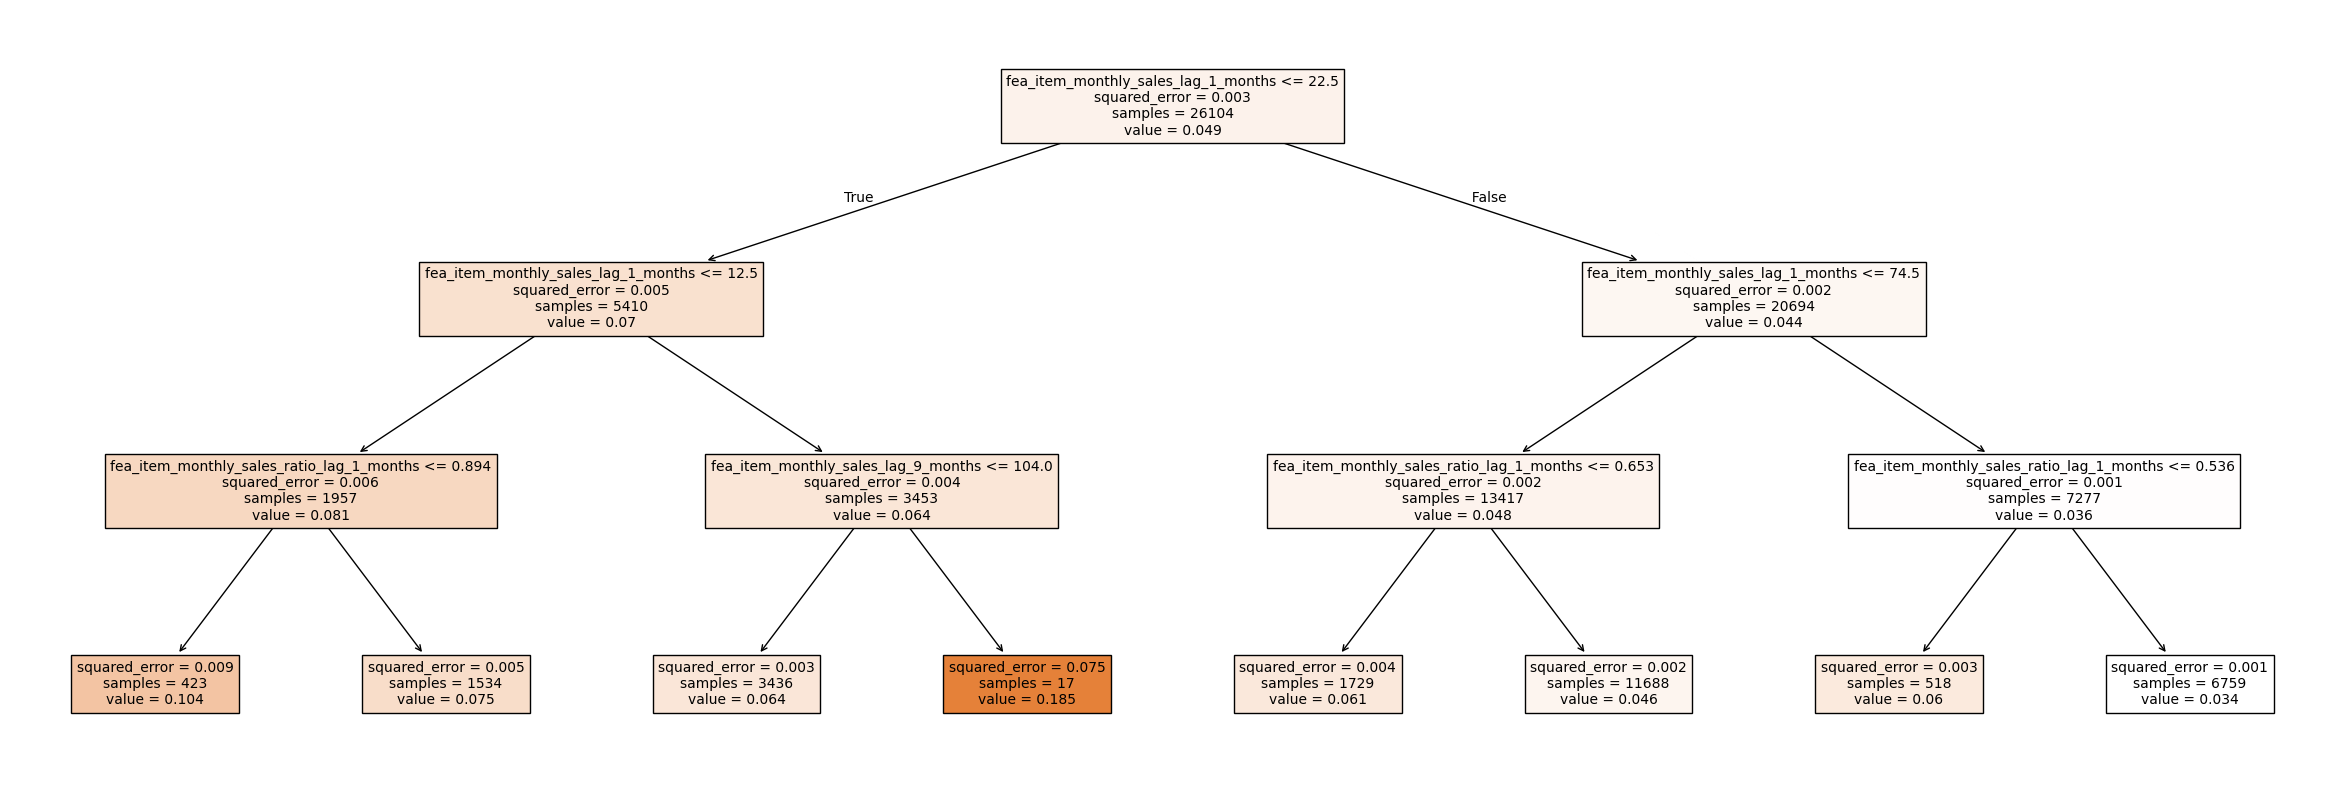

In [155]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 10))
plot_tree(regressor, feature_names=lag_features, filled=True, fontsize=10)
plt.show()